# **Feature Extractor Transfer Training Using SFNet20 pretrained model with SPhereFace2 loss function**

## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
from torch import nn
from torchvision import transforms

# import torch.distributed as dist
# import torch.utils.data.distributed

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# clone the opensphere github
!git clone https://github.com/ydwen/opensphere

[INFO] Couldn't find torchinfo... installing it.
Cloning into 'opensphere'...
remote: Enumerating objects: 636, done.
remote: Counting objects: 100% (392/392), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 636 (delta 328), reused 255 (delta 214), pack-reused 244
Receiving objects: 100% (636/636), 6.72 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (359/359), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sun May  7 04:46:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Define working path (make sure you have this folder on your working space, otherwise, you should write some codes to create it)

In [ ]:
working_path = 'drive/MyDrive/SphereFace2' # you can modify this path to suit your working directory
data_path = working_path + '/data'

In [ ]:
origin_data_path = data_path + '/VN-celeb' 
train_dir = data_path + "/train"
test_dir = data_path + "/test"

## 1. Get and tranform data

### 1.1 Spliting the dataset into train and test set
(Run this only if you not split your data yet)

In [ ]:
import zipfile
zip_ref = zipfile.open(os.path.join(origin_data_path, 'VN-celeb.zip'))
zip_ref.extractall(origin_data_path)

In [ ]:
import os
import shutil
import random

percentage = 80

folders = os.listdir(origin_data_path)
num_folders = len(folders)
num_to_move = int(num_folders * percentage / 100)

folders_to_move = random.sample(folders, num_to_move)

for folder in folders_to_move:
    folder_path = os.path.join(origin_data_path, folder)
    dest_path = os.path.join(train_dir, folder)
    shutil.move(folder_path, dest_path)

In [ ]:
for folder in [ele for ele in folders if ele not in folders_to_move]:
    folder_path = os.path.join(origin_data_path, folder)
    dest_path = os.path.join(test_dir, folder)
    shutil.move(folder_path, dest_path)

In [ ]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(train_dir)

In [ ]:
walk_through_dir(test_dir)

Random image path: drive/MyDrive/SphereFace2/data/test/51/12.png
Image class: 51
Image height: 128
Image width: 128


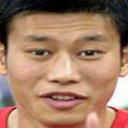

In [ ]:
import random 
from PIL import Image
from pathlib import Path

# Set seed
# random.seed(42)

# 1. Get all image paths 
image_path_list = list(Path(data_path).glob("*/*/*.png"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Function to create pair of image for test set and save the label into a csv file

In [ ]:
import os
import csv
import random

def generate_csv_file(dataset_path, csv_file_path):
    # Create a list of class names
    class_names = os.listdir(dataset_path)

    # Create a dictionary to store image paths by class
    image_paths_by_class = {}
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        image_names = os.listdir(class_path)
        image_paths = [os.path.join(class_path, image_name) for image_name in image_names]
        image_paths_by_class[class_name] = image_paths

    # Create a list of all possible image pairs
    image_pairs = []
    for class_name in class_names:
        image_paths = image_paths_by_class[class_name]
        for i in range(len(image_paths)):
            for j in range(i + 1, len(image_paths)):
                image_pairs.append((image_paths[i], image_paths[j], 1))

    # Add an equal number of non-matching image pairs
    num_pairs_per_class = len(image_pairs) // len(class_names)
    for class_name in class_names:
        image_paths = image_paths_by_class[class_name]
        other_class_names = [n for n in class_names if n != class_name]
        for i in range(num_pairs_per_class):
            other_class_name = random.choice(other_class_names)
            other_image_path = random.choice(image_paths_by_class[other_class_name])
            image_path = random.choice(image_paths)
            image_pairs.append((image_path, other_image_path, 0))

    # Shuffle the image pairs
    random.shuffle(image_pairs)

    with open(csv_file_path, 'w', newline='') as csv_file:
      writer = csv.writer(csv_file)
      for pair in image_pairs:
        writer.writerow(pair)


In [ ]:
generate_csv_file(test_dir, os.path.join(test_dir, 'test_set.csv'))

### 1.2 Transform input image shape and load the dataset into the dataloader

#### 1.2.0 Helper functions



> Create a custom dataset class for test set



In [ ]:
from torchvision import datasets
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Build a custom dataset class for test dataset
class TestDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img1_path = self.img_labels.iloc[idx, 0]
        img2_path = self.img_labels.iloc[idx, 1]
        image1 = Image.open(img1_path)
        image2 = Image.open(img2_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        if self.target_transform:
            label = self.target_transform(label)
        return image1, image2, label

#### 1.2.1 Prepare data for training and testing SFNet20 model

In [ ]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
data_transform = transforms.Compose([
  # Resize our images to 112x112
  transforms.Resize(size=(112, 112)),
  # Turn the image into a torch.Tensor
  transforms.ToTensor(),
  normalize
])

In [ ]:
# Use ImageFolder to create train dataset
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target 

# Use above class to create test dataset
test_data = TestDataset(annotations_file=os.path.join(test_dir, 'test_set.csv'), 
                        transform=data_transform)

Have a look at our data

In [ ]:
len(train_data), len(test_data)

(18633, 142963)

In [ ]:
train_data[0]

(tensor([[[ 0.2235, -0.1373, -0.4667,  ..., -0.0980,  0.4824,  0.8118],
          [-0.2706, -0.4745, -0.6078,  ..., -0.3725,  0.1843,  0.6314],
          [-0.6549, -0.6941, -0.7176,  ..., -0.5608, -0.1451,  0.3647],
          ...,
          [-0.8431, -0.7804, -0.6941,  ..., -0.8353, -0.8196, -0.7882],
          [-0.8588, -0.8039, -0.7176,  ..., -0.8275, -0.8196, -0.7961],
          [-0.8588, -0.8275, -0.7490,  ..., -0.8275, -0.8118, -0.7882]],
 
         [[ 0.2863, -0.1059, -0.4745,  ...,  0.0353,  0.6000,  0.8745],
          [-0.2549, -0.4745, -0.6157,  ..., -0.2314,  0.3333,  0.7412],
          [-0.6549, -0.7020, -0.7333,  ..., -0.4431,  0.0039,  0.4980],
          ...,
          [-0.7961, -0.7412, -0.6706,  ..., -0.7961, -0.7647, -0.7412],
          [-0.8196, -0.7725, -0.6941,  ..., -0.7882, -0.7647, -0.7412],
          [-0.8353, -0.7882, -0.7176,  ..., -0.7804, -0.7569, -0.7333]],
 
         [[ 0.2392, -0.1216, -0.4510,  ...,  0.1137,  0.6392,  0.8980],
          [-0.2627, -0.4588,

In [ ]:
test_data[1]

(tensor([[[-0.8902, -0.8980, -0.8980,  ..., -0.8588, -0.8510, -0.8118],
          [-0.8824, -0.8902, -0.8980,  ..., -0.8196, -0.8196, -0.7882],
          [-0.8745, -0.8824, -0.9059,  ..., -0.7098, -0.7176, -0.7098],
          ...,
          [ 0.2000,  0.2078,  0.2078,  ..., -0.5922, -0.5843, -0.5843],
          [ 0.2000,  0.2078,  0.1922,  ..., -0.5843, -0.5686, -0.5686],
          [ 0.1765,  0.1922,  0.1843,  ..., -0.5765, -0.5686, -0.5686]],
 
         [[-0.9765, -0.9686, -0.9608,  ..., -0.9373, -0.9373, -0.9216],
          [-0.9686, -0.9686, -0.9608,  ..., -0.8980, -0.9137, -0.9059],
          [-0.9765, -0.9686, -0.9608,  ..., -0.8588, -0.8980, -0.9137],
          ...,
          [-0.5765, -0.5843, -0.5843,  ..., -0.7020, -0.7020, -0.7020],
          [-0.5922, -0.6000, -0.5922,  ..., -0.6706, -0.6706, -0.6784],
          [-0.5922, -0.6000, -0.5922,  ..., -0.6549, -0.6627, -0.6784]],
 
         [[-0.9843, -0.9843, -0.9765,  ..., -0.9608, -0.9451, -0.9216],
          [-0.9843, -0.9765,

Load data into dataloader

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=1024, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=True, pin_memory=True)

## 2. Base Model
For Face Verification problem, we decided to use a pretrained backbone classification model and then do tranfer learning (feature extraction) using the SphereFace2 loss function.

### 2.0 Build functions to train and test the model

In [ ]:
"""
Functions for training a PyTorch model.
"""
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        # y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    # train_acc = train_acc / len(dataloader)
    return train_loss

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          train_checkpoint_path: str,
          train_loss_checkpoint_path: str,
          best_train_checkpoint_path: str
          ) -> Dict[str, List]:
    
    # Make sure model on target device
    model.to(device)

    # Load Checkpoint
    train_checkpoint = torch.load(train_checkpoint_path)
    model.load_state_dict(train_checkpoint['model_state_dict'])
    loss_fn.load_state_dict(train_checkpoint['head_state_dict'])
    optimizer.load_state_dict(train_checkpoint['optimizer_state_dict'])
    prev_epoch = train_checkpoint['epoch']

    results = torch.load(train_loss_checkpoint_path)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(prev_epoch, epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          # f"train_acc: {train_acc:.4f} | "
        )

        # Update results dictionary
        results.append(train_loss)

        # save checkpoint

        # check whether this is the best loss
        if os.path.exists(best_train_checkpoint_path):
            best_train_checkpoint = torch.load(best_train_checkpoint_path)
            if best_train_checkpoint['loss'] > train_loss:
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'head_state_dict': loss_fn.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': train_loss
                }, best_train_checkpoint_path)
        else:
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'head_state_dict': loss_fn.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
            }, best_train_checkpoint_path)

        # save train checkpoint
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'head_state_dict': loss_fn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, train_checkpoint_path)
        
        # save loss checkpoint
        torch.save(results, train_loss_checkpoint_path)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
"""
Functions for testing a PyTorch model.
"""
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    thresholds = torch.FloatTensor([-1 + 0.01*x for x in range(201)]).to(device)
    tp = torch.zeros_like(thresholds).to(device)
    fp = torch.zeros_like(thresholds).to(device)
    tn = torch.zeros_like(thresholds).to(device)
    fn = torch.zeros_like(thresholds).to(device)

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X1, X2, y) in enumerate(dataloader):
            # Send data to target device
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # 1. Forward pass
            embeding1 = model(X1)
            embeding2 = model(X2)
            embeding1_norm = F.normalize(embeding1, dim=1)
            embeding2_norm = F.normalize(embeding2, dim=1)
            test_pred_logits = torch.sum(input=torch.mul(embeding1_norm, embeding2_norm), dim=1, keepdim=False)
            
            # Calculate and accumulate accuracy, tp, tn, fp, fn
            for i in range(201):
                test_pred = torch.where(test_pred_logits >= thresholds[i], 1.0, 0.0)
                tp[i] += torch.sum(torch.where(test_pred == 1.0, y, 0.0))
                tn[i] += torch.sum(torch.where(test_pred == 0.0, torch.subtract(1.0,y), 0.0))
                fp[i] += torch.sum(torch.where(test_pred == 1.0, torch.subtract(1.0,y), 0.0))
                fn[i] += torch.sum(torch.where(test_pred == 0.0, y, 0.0))

    # Calculate tpr, fpr for ploting ROC curve
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    acc = (tp + tn) / (tp + fn + fp + tn)
    return thresholds, tpr, fpr, acc

In [ ]:
class_num = len(train_data.classes)
class_num

816



> Import SFNet20 model and sphereface2 loss from openphere



In [ ]:
from opensphere.model.backbone import sfnet
from opensphere.model.head import sphereface2



> Function to plotting loss curve



In [ ]:
def plot_loss_curves(train_loss):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    epochs = range(len(train_loss))

    plt.figure(figsize=(30, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

### 2.1 Building the model using SFNet20 as backbone:



> Load the pretrained state_dict of the SFNet20 from opensphere and transform it into state_dict without DataParallel



In [ ]:
state_dict = torch.load('drive/MyDrive/SphereFace2/pretrained_weights/backbone_100000.pth')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
new_state_dict



> Initialize the base model and load the weights from state_dict



In [ ]:
base_model = sfnet.sfnet20().to(device)
base_model.load_state_dict(new_state_dict)
base_model.eval()

SFNet(
  (features): Identity()
  (layer1): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
    )
  )
  (layer2): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Identity()
    )
    (2): BasicBlock(
      (conv1): Conv2d(1

In [ ]:
base_model.fc

Linear(in_features=25088, out_features=512, bias=True)



> Freeze all the parameters except the last layer



In [ ]:
from torchinfo import summary

summary(model=base_model,
        input_size=(1, 3, 112, 112), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SFNet (SFNet)                            [1, 3, 112, 112]     [1, 512]             --                   True
├─Sequential (layer1)                    [1, 3, 112, 112]     [1, 64, 56, 56]      --                   True
│    └─ConvBlock (0)                     [1, 3, 112, 112]     [1, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1)               [1, 3, 112, 112]     [1, 64, 56, 56]      1,792                True
│    │    └─Identity (bn1)               [1, 64, 56, 56]      [1, 64, 56, 56]      --                   --
│    │    └─ReLU (relu)                  [1, 64, 56, 56]      [1, 64, 56, 56]      --                   --
│    └─BasicBlock (1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      36,928               True
│    │    └─Identi

In [ ]:
# Freeze all of layers in the base model
for param in base_model.parameters():
  # print(param)
  param.requires_grad = False
# Unfreeze the last layer:
for param in base_model.fc.parameters():
  # print(param)
  param.requires_grad = True

In [ ]:
summary(model=base_model,
        input_size=(1, 3, 112, 112), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SFNet (SFNet)                            [1, 3, 112, 112]     [1, 512]             --                   Partial
├─Sequential (layer1)                    [1, 3, 112, 112]     [1, 64, 56, 56]      --                   False
│    └─ConvBlock (0)                     [1, 3, 112, 112]     [1, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [1, 3, 112, 112]     [1, 64, 56, 56]      (1,792)              False
│    │    └─Identity (bn1)               [1, 64, 56, 56]      [1, 64, 56, 56]      --                   --
│    │    └─ReLU (relu)                  [1, 64, 56, 56]      [1, 64, 56, 56]      --                   --
│    └─BasicBlock (1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (36,928)             False
│    │    



> Initialize the SphereFace2 loss function



In [ ]:
head_module = sphereface2.SphereFace2(512, class_num).to(device)
# Number of trainable parameters of SphereFace2 head:
sum(p.numel() for p in head_module.parameters())

417793

In [ ]:
# Concatenate parameters from base model and SphereFace2 head into a list
trainable_parameters = list(base_model.parameters()) + list(head_module.parameters())
trainable_parameters



> Define the optimizer and train the model



In [ ]:
optimizer = torch.optim.SGD(params=trainable_parameters, # we want to optimize the parameters present in our model
                            lr=0.01, # lr = learning rate = possibly the most important hyperparameter you can set
                            momentum=0.9,
                            weight_decay=0.0005)
loss_fn = head_module

In [ ]:
checkpoint_dir = data_path + '/sfnet20_train'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
train_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pt')
best_train_checkpoint_path = os.path.join(checkpoint_dir, 'best_checkpoint.pt')
train_loss_checkpoint_path = os.path.join(checkpoint_dir, 'loss_checkpoint.pt')

In [ ]:
# Initialize the checkpoint if no checkpoint found
if not os.path.exists(train_checkpoint_path):
    torch.save({
            'epoch': 0,
            'model_state_dict': base_model.state_dict(),
            'head_state_dict': loss_fn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, train_checkpoint_path)
if not os.path.exists(train_loss_checkpoint_path):
    torch.save([], train_loss_checkpoint_path)

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=base_model,
                train_dataloader=train_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=500,
                device=device,
                train_checkpoint_path=train_checkpoint_path,
                train_loss_checkpoint_path=train_loss_checkpoint_path,
                best_train_checkpoint_path=best_train_checkpoint_path)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

0it [00:00, ?it/s]

[INFO] Total training time: 2.006 seconds




> Visualize



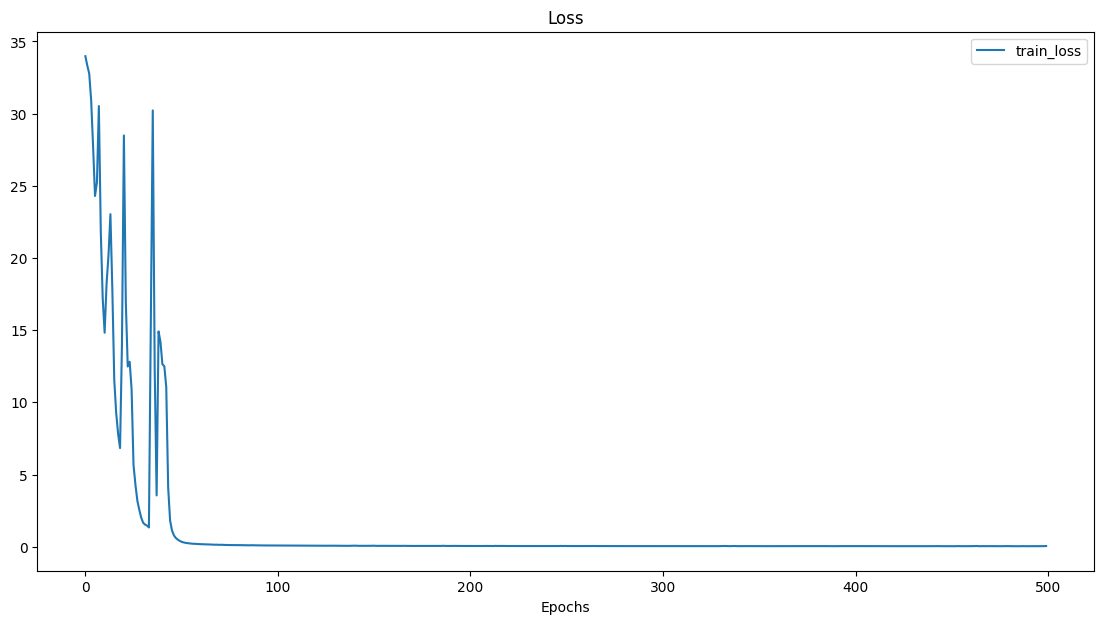

In [ ]:
train_loss = torch.load(train_loss_checkpoint_path)
plot_loss_curves(train_loss)

In [ ]:
best_result = torch.load(best_train_checkpoint_path)
best_result['epoch']

494

In [ ]:
base_model.load_state_dict(best_result['model_state_dict'])

<All keys matched successfully>

In [ ]:
test_checkpoint_path = os.path.join(checkpoint_dir, 'test_checkpoint.pt')
if not os.path.exists(test_checkpoint_path):
    thresholds, tpr, fpr, acc = test_step(model=base_model, 
                          dataloader=test_dataloader, 
                          device=device)
    torch.save({
        'thresholds': thresholds,
        'tpr': tpr,
        'fpr': fpr,
        'accuracy': acc
    }, test_checkpoint_path)
else:
    test_result = torch.load(test_checkpoint_path)
    thresholds = test_result['thresholds']
    tpr = test_result['tpr']
    fpr = test_result['fpr']
    acc = test_result['accuracy']

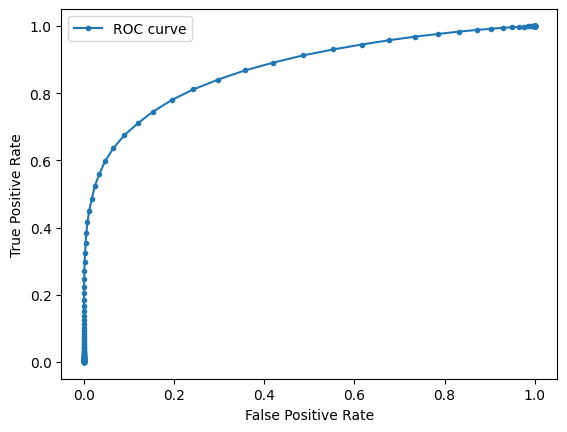

In [ ]:
# plot the roc curve for the model
plt.plot(fpr.cpu(), tpr.cpu(), marker='.', label='ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

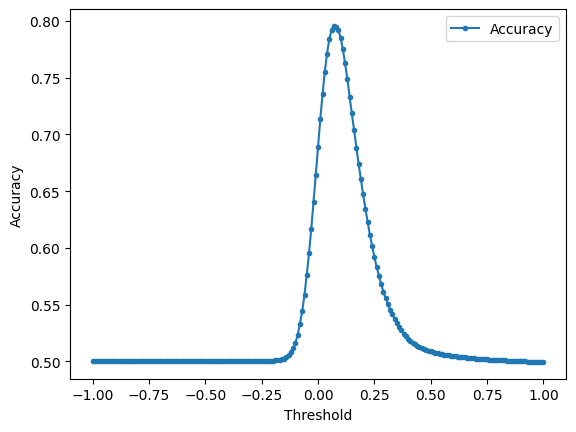

In [ ]:
# plot the accuracy w.r.t threshold for the model
plt.plot(thresholds.cpu(), acc.cpu(), marker='.', label='Accuracy')
# axis labels
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# choose the best threshold for the model using Youden’s J statistic
J = torch.sub(tpr, fpr).cpu()
idx = torch.argmax(J)
best_thresh = thresholds[idx]
best_thresh_acc = acc[idx]
print(f'Best threshold: {best_thresh}, Accuracy: {best_thresh_acc}')

Best threshold: 0.07000000029802322, Accuracy: 0.7956604361534119


In [ ]:
threshold_path = os.path.join(checkpoint_dir, 'threshold.pt')
if not os.path.exists(threshold_path):
    torch.save(best_thresh, threshold_path)

## 3. Prepare the model for mobile app

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile

mobile_model_dir = working_path + '/mobile_model'
if not os.path.exists(mobile_model_dir):
    os.mkdir(mobile_model_dir)

base_model.eval()

scripted_model = torch.jit.script(base_model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(os.path.join(mobile_model_dir,"SFNet20.ptl"))

print("model successfully exported")

model successfully exported
